In [8]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:

with open("binwvsrin_oldNaNs.pkl", "rb") as f:
    binwvsrin_oldNaNs = pickle.load(f)
with open("binwvsrin_newNaNs.pkl", "rb") as f:
    binwvsrin_newNaNs = pickle.load(f)

binwvsrinNANs = {}
binwvsrinNaNs = binwvsrin_oldNaNs | binwvsrin_newNaNs

## Find Rin bins

### Extract excitatory gain, peak timing, and amplitude

In [26]:
import numpy as np
import pandas as pd
from collections import defaultdict

def extract_excitatory_features(binned_waveforms):
    """
    Extract excitatory peak gain, peak timing, and peak amplitude for each cell.
    
    Parameters:
        binned_waveforms: dict
            Keys: (freq, signal_type, cell_type, cell_id, Rin)
            Values: DataFrames with waveform data
    
    Returns:
        DataFrame with columns: 
        ['Cell', 'Cell Type', 'Rin', 'Freq', 'Freq Bin', 'Peak Gain', 'Peak Phase', 'Peak Amplitude']
    """
    records = []
    # Assuming phase goes from 0.01 to 1 by 0.02 increments (50 points)
    phase = np.arange(0.01, 1.00001, 0.02)

    for (freq, signal_type, cell_type, cell_id, rin), df in binned_waveforms.items():
        # Check data shape matches expected waveform shape (50 time points x 4 columns)
        if df.shape != (50, 4):
            continue
        # Focus on Excitatory signals only
        if group_EI(signal_type) != 'Excitatory':
            continue

        norm_currents = df['Normalized Current'].values
        peak_idx = np.argmax(norm_currents)
        peak_gain = norm_currents[peak_idx]
        peak_phase = phase[peak_idx]
        peak_amplitude = norm_currents[peak_idx]  # Same as gain here

        freq_bin = get_freq_bin(freq)

        records.append({
            'Cell': cell_id,
            'Cell Type': group_iSMN(cell_type),
            'Rin': rin,
            'Freq': freq,
            'Freq Bin': freq_bin,
            'Peak Gain': peak_gain,
            'Peak Phase': peak_phase,
            'Peak Amplitude': peak_amplitude
        })

    return pd.DataFrame(records)


In [27]:
def bin_rin(rin_value):
    if rin_value < 200:
        return "<200"
    elif rin_value < 400:
        return "200-400"
    else:
        return "400+"
def get_freq_bin(freq):
    if freq < 15:
        return "<15"
    elif 15 <= freq < 25:
        return "15–25"
    elif 25 <= freq < 35:
        return "25–35"
    elif 35 <= freq < 45:
        return "35–45"
    else:
        return "45+"
def group_EI(signal_type):
    if signal_type in ["Inhibitory", "Inhibitory (Rs compensation)"]:
        return "Inhibitory"
    if signal_type in ["Excitatory", "Excitatory (Rs compensation)"]:
        return "Excitatory"
    return signal_type
def group_iSMN(cell_type):
    cell_type = cell_type.strip()
    if cell_type in ["iSMN (dorsal) muscle", "iSMN"]:
        return "iSMN"
    if cell_type == "vSMN":
        return "vSMN"
    return cell_type


def aggregate_features(features_df):
    features_df['Rin Bin'] = features_df['Rin'].apply(bin_rin)
    
    # Group by Cell Type, Rin Bin, Frequency Bin
    grouped = features_df.groupby(['Cell Type', 'Rin Bin', 'Freq Bin'])
    
    summary = grouped.agg({
        'Peak Gain': ['mean', 'std', 'count'],
        'Peak Phase': ['mean', 'std'],
        'Peak Amplitude': ['mean', 'std']
    })
    
    # Flatten multi-index columns
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary = summary.reset_index()
    
    return summary



In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_by_factor(summary_df, feature='Peak Gain_mean', hue='Cell Type', title=None):
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=summary_df,
        x='Freq Bin',
        y=feature,
        hue=hue,
        ci=None,
        palette='tab10'
    )
    plt.title(title or f"{feature} by Frequency Bin and {hue}")
    plt.ylabel(feature)
    plt.xlabel("Frequency Bin")
    plt.legend(title=hue)
    plt.show()

def plot_raw_feature_distribution(features_df, feature='Peak Gain', group_by='Cell Type'):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=features_df, x='Freq Bin', y=feature, hue=group_by, palette='tab10')
    plt.title(f"{feature} Distribution by Frequency Bin and {group_by}")
    plt.ylabel(feature)
    plt.xlabel("Frequency Bin")
    plt.legend(title=group_by)
    plt.show()


In [29]:

def variance_explained(features_df, feature_col='Peak Gain'):
    features_df['Rin Bin'] = features_df['Rin'].apply(bin_rin)
    formula = f"{feature_col} ~ C(`Cell Type`) + C(`Rin Bin`)"
    model = ols(formula, data=features_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print(f"ANOVA results for {feature_col} ~ Cell Type + Rin Bin:")
    print(anova_table)
    return anova_table

In [31]:
summary_df

,Cell Type,Rin Bin,Freq Bin,Peak Gain_mean,Peak Gain_std,Peak Gain_count,Peak Phase_mean,Peak Phase_std,Peak Amplitude_mean,Peak Amplitude_std
0,CaP,<200,15–25,0.779227,0.064894,723,0.685438,0.249803,0.779227,0.064894
1,CaP,<200,25–35,0.820052,0.093175,667,0.599226,0.308394,0.820052,0.093175
2,CaP,<200,35–45,0.963601,0.028725,78,0.494310,0.313497,0.963601,0.028725
3,CaP,<200,45+,0.987986,0.006704,13,0.540000,0.323646,0.987986,0.006704
4,CaP,<200,<15,0.771906,0.074939,110,0.431472,0.365051,0.771906,0.074939
5,MiP,<200,15–25,0.798366,0.059378,643,0.736287,0.220019,0.798366,0.059378
6,MiP,<200,25–35,0.813124,0.078091,1253,0.691665,0.300016,0.813124,0.078091
7,MiP,<200,35–45,0.929944,0.074322,158,0.507854,0.353383,0.929944,0.074322
8,MiP,<200,45+,0.964414,0.047081,44,0.441940,0.304911,0.964414,0.047081
9,MiP,<200,<15,0.808879,0.071456,127,0.520259,0.338927,0.808879,0.071456


/var/folders/40/qf3btjqs32l1pmzzyts7w9pmh2xrdg/T/ipykernel_74347/2503161778.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


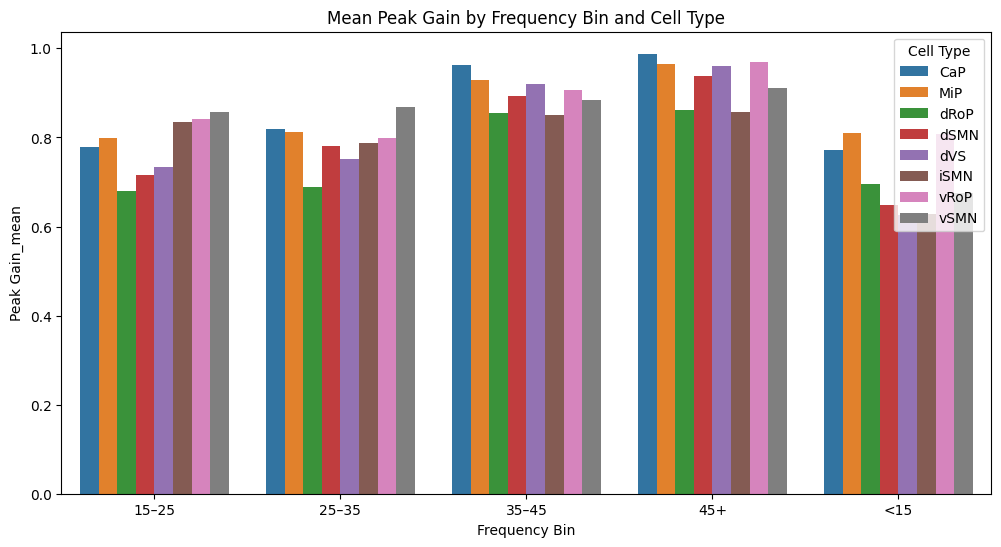

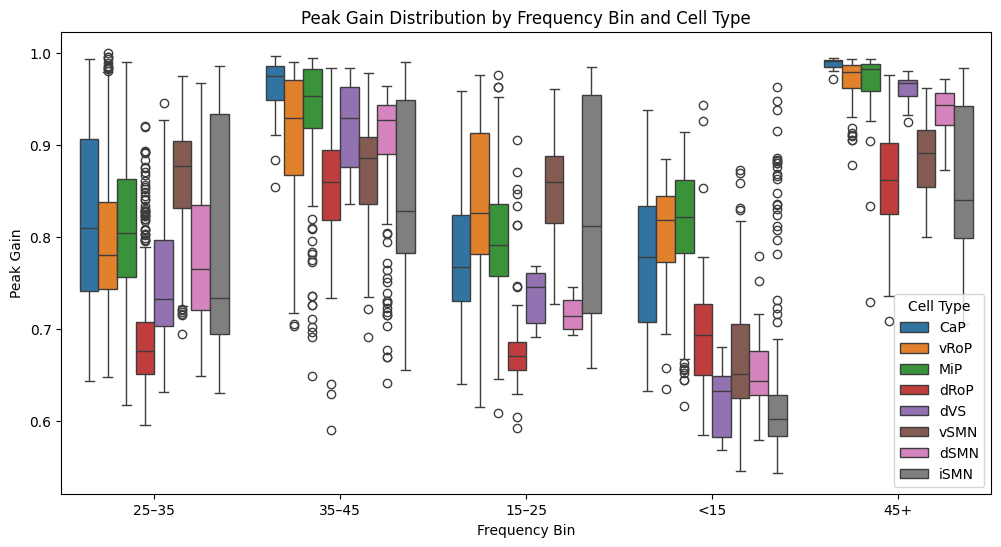

SyntaxError: invalid syntax (<unknown>, line 1)

In [30]:
# 1. Extract features
features_df = extract_excitatory_features(binwvsrinNaNs)

# 2. Aggregate by groups
summary_df = aggregate_features(features_df)

# 3a. Plot mean Peak Gain by Cell Type
plot_feature_by_factor(summary_df, feature='Peak Gain_mean', hue='Cell Type', 
                       title="Mean Peak Gain by Frequency Bin and Cell Type")

# 3b. Plot distribution of Peak Gain by Cell Type (raw data)
plot_raw_feature_distribution(features_df, feature='Peak Gain', group_by='Cell Type')

# 4. Variance explained analysis for Peak Gain
variance_explained(features_df, feature_col='Peak Gain')

# You can repeat plotting and analysis for 'Peak Phase' and 'Peak Amplitude' similarly
